<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction
<hr style = "border:2px solid black" ></hr>


**What?** Mean-Variance optimisation



# Mean-Variance Optimization
<hr style = "border:2px solid black" ></hr>


- MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

- Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

- Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, $μ_{PF}$. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$




# Markovitz curse
<hr style = "border:2px solid black" ></hr>


- The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. 

- The high condition number induces numerical instability, which in turn gives rise to the **Markovitz curse**: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm.



# Imports
<hr style = "border:2px solid black" ></hr>

In [1]:
import os
import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from pathlib import Path

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)

In [3]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

# Get data
<hr style = "border:2px solid black" ></hr>


- These are the instructions for downloading the Quandl Wiki stock prices. 
- Step-by-step procedure:
    1. Follow the instructions to create a free [NASDAQ account](https://data.nasdaq.com/sign-up)
    2. If the link above does not work use [this]((https://data.nasdaq.com/databases/WIKIP/documentation)) one to sign-up 
    3. [Download](https://data.nasdaq.com/tables/WIKIP/WIKI-PRICES/export) the entire WIKI/PRICES data
    4. Extract the .zip file,
    5. Move to this directory and rename to `wiki_prices.csv`
    6. Run the below code to store in fast HDF format. 



In [4]:
# Check if .csv is present
!ls *.csv

wiki_prices.csv             wiki_prices_ticker_list.csv


In [5]:
# read csv with pandas
df = (pd.read_csv('wiki_prices.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())

In [6]:
# Some sanity check on the dataframe
df.info(null_counts=True)

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_58909/1709259513.py:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Data columns (total 12 columns):
 #   Column       Non-Null Count     Dtype  
---  ------       --------------     -----  
 0   open         15388776 non-null  float64
 1   high         15389259 non-null  float64
 2   low          15389259 non-null  float64
 3   close        15389313 non-null  float64
 4   volume       15389314 non-null  float64
 5   ex-dividend  15389314 non-null  float64
 6   split_ratio  15389313 non-null  float64
 7   adj_open     15388776 non-null  float64
 8   adj_high     15389259 non-null  float64
 9   adj_low      15389259 non-null  float64
 10  adj_close    15389313 non-null  float64
 11  adj_volume   15389314 non-null  float64
dtypes: float64(12)
memory usage: 1.4+ GB


In [7]:
# Put data into an h5 format
DATA_STORE = Path('assets.h5')
with pd.HDFStore(DATA_STORE) as store:
    store.put('quandl/wiki/prices', df)

- The following code downloads the current S&P 500 constituents from [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df = pd.read_html(url, header=0)[0]

In [9]:
df.head(5)

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [10]:
df.columns = ['ticker', 'name', 'sec_filings', 'gics_sector', 'gics_sub_industry',
              'location', 'first_added', 'cik', 'founded']
df = df.drop('sec_filings', axis=1).set_index('ticker')

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 503 entries, MMM to ZTS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               503 non-null    object
 1   gics_sector        503 non-null    object
 2   gics_sub_industry  503 non-null    object
 3   location           503 non-null    object
 4   first_added        458 non-null    object
 5   cik                503 non-null    int64 
 6   founded            503 non-null    object
dtypes: int64(1), object(6)
memory usage: 31.4+ KB
None


In [12]:
# Saving data locally
with pd.HDFStore(DATA_STORE) as store:
    store.put('sp500/stocks', df)

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_58909/978421352.py:3: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['name', 'gics_sector', 'gics_sub_industry', 'location', 'first_added',
       'founded'],
      dtype='object')]

  store.put('sp500/stocks', df)


In [13]:
# Reading the data from file 
with pd.HDFStore('assets.h5') as store:
    sp500_stocks = store['sp500/stocks']

In [14]:
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ABMD,Abiomed,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [15]:
with pd.HDFStore('assets.h5') as store:
    prices = (store['quandl/wiki/prices']
              .adj_close
              .unstack('ticker')
              .filter(sp500_stocks.index)
              .sample(n=30, axis=1))

In [16]:
prices.head(5)

ticker,DHI,AEP,GIS,WM,EW,IDXX,TXN,MSI,HII,CDNS,...,BMY,LMT,ZION,APH,HCA,NEE,BR,CCL,DRI,ADP
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Compute Inputs
<hr style = "border:2px solid black" ></hr>

### Compute Returns

In [17]:
start = 2008
end = 2017

Create month-end monthly returns and drop dates that have no observations:

In [18]:
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DHI     521 non-null    float64
 1   AEP     521 non-null    float64
 2   GIS     521 non-null    float64
 3   WM      521 non-null    float64
 4   EW      521 non-null    float64
 5   IDXX    521 non-null    float64
 6   TXN     521 non-null    float64
 7   MSI     521 non-null    float64
 8   CDNS    521 non-null    float64
 9   GWW     521 non-null    float64
 10  PPL     521 non-null    float64
 11  CPB     521 non-null    float64
 12  PEP     521 non-null    float64
 13  JNPR    521 non-null    float64
 14  USB     521 non-null    float64
 15  HSY     521 non-null    float64
 16  KMB     521 non-null    float64
 17  WY      521 non-null    float64
 18  MMM     521 non-null    float64
 19  BMY     521 non-null    float64
 20  LMT     521 non-null    float64
 21  ZION    

### Set  Parameters

In [19]:
stocks = weekly_returns.columns

In [20]:
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(28, 521)

In [21]:
NUM_PF = 100000 # no of portfolios to simulate

In [22]:
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [23]:
periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

### Compute Mean Returns, Covariance and Precision Matrix

In [24]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

The precision matrix is the inverse of the covariance matrix:

In [25]:
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

### Risk-Free Rate

Load historical 10-year Treasury rate:

In [26]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

In [27]:
rf_rate = treasury_10yr_monthly.mean()

# Simulate Random Portfolios
<hr style = "border:2px solid black" ></hr>

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [28]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [29]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [30]:
df = pd.DataFrame(simul_wt)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,...,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,3.545808e-02,3.627223e-02,3.549418e-02,3.588723e-02,3.604591e-02,3.475231e-02,3.555899e-02,3.542932e-02,3.540845e-02,3.619149e-02,...,3.466589e-02,3.586070e-02,3.593449e-02,3.520591e-02,3.659559e-02,3.641537e-02,3.563908e-02,3.567947e-02,3.585288e-02,3.554225e-02
std,1.189767e-01,1.208676e-01,1.189454e-01,1.207409e-01,1.204339e-01,1.173262e-01,1.195299e-01,1.190809e-01,1.193539e-01,1.210852e-01,...,1.170147e-01,1.200968e-01,1.197701e-01,1.186168e-01,1.220971e-01,1.215610e-01,1.204518e-01,1.191968e-01,1.200956e-01,1.186928e-01
min,4.166636e-102,4.679656e-125,5.836624e-119,7.051713e-103,2.567247e-105,1.906690e-96,1.365791e-112,1.763581e-118,1.926568e-120,2.888351e-95,...,1.045473e-116,6.711143e-98,2.704086e-89,1.018302e-117,2.764121e-98,4.358036e-117,5.062849e-137,3.462650e-101,4.043881e-94,1.283151e-102
25%,5.716611e-13,5.963362e-13,6.222785e-13,6.730975e-13,6.258510e-13,5.318619e-13,4.864309e-13,6.343054e-13,4.807505e-13,5.456637e-13,...,6.057140e-13,5.601322e-13,5.385356e-13,5.315339e-13,5.676801e-13,6.111818e-13,5.776705e-13,5.547247e-13,6.204444e-13,5.125139e-13
50%,5.905824e-07,6.170578e-07,6.614423e-07,6.664599e-07,6.082049e-07,6.168840e-07,5.585675e-07,6.154866e-07,6.144714e-07,6.044960e-07,...,5.700626e-07,6.355634e-07,6.146371e-07,5.648323e-07,6.897711e-07,5.993280e-07,6.130145e-07,5.801322e-07,6.843108e-07,5.624906e-07
75%,2.064626e-03,2.095705e-03,2.041344e-03,2.019354e-03,2.018936e-03,1.953304e-03,2.028786e-03,2.007622e-03,2.039945e-03,2.010634e-03,...,1.889520e-03,2.049309e-03,2.001652e-03,1.909114e-03,2.149966e-03,2.016937e-03,1.960781e-03,2.040627e-03,2.031648e-03,2.051669e-03
max,9.972010e-01,9.978493e-01,9.948924e-01,9.974678e-01,9.965742e-01,9.995422e-01,9.987574e-01,9.995418e-01,9.986125e-01,9.996608e-01,...,9.949519e-01,9.963151e-01,9.987022e-01,9.993707e-01,9.995322e-01,9.995686e-01,9.953485e-01,9.980261e-01,9.995807e-01,9.992834e-01


Max Sharpe: 16.13%, 21.71%


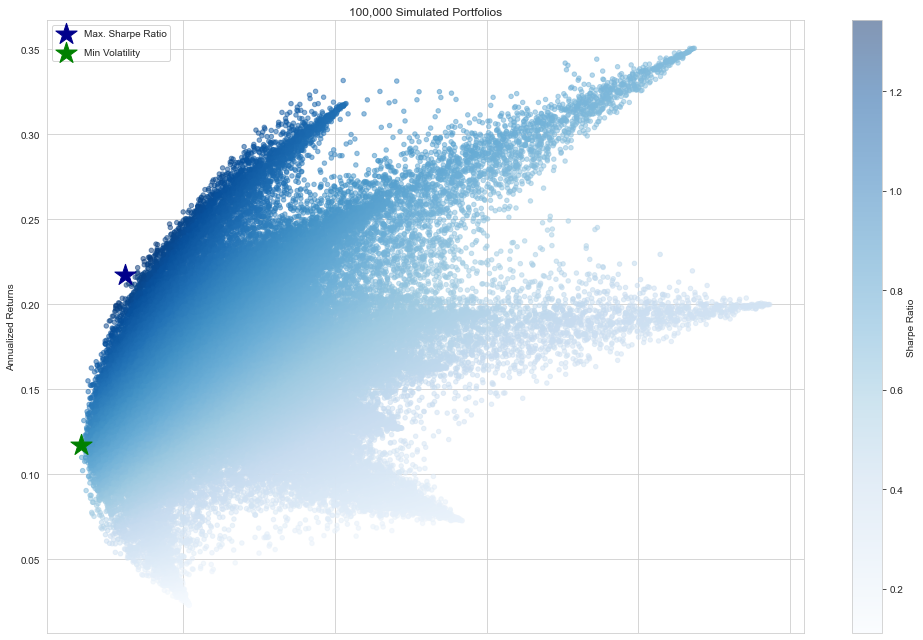

In [31]:
# Plot simulated portfolios
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Now we'll set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [32]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [33]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [34]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize, given the constraints that the weights are bounded by [-1, 1], if short trading is permitted, and [0, 1] otherwise, and sum to one in absolute terms.

In [35]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [36]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x))-1}

In [37]:
def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [38]:
def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Unfortunately, expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [39]:
def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [40]:
def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [41]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

In [42]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.227729            0.164993       0.751532
std                         0.066254            0.045018       0.200197
min                         0.131964            0.022878       0.109593
25%                         0.180603            0.136799       0.622846
50%                         0.209489            0.163524       0.778553
75%                         0.257952            0.188344       0.892110
max                         0.583438            0.351356       1.305893


In [43]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.163234
Annualized Returns               0.213665
Sharpe Ratio                     1.305893
Name: 29035, dtype: float64

### Get Max Sharpe PF

In [44]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_58909/511534947.py:2: OptimizeWarning: Unknown solver options: tol
  return minimize(fun=neg_sharpe_ratio,


In [45]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.219289
sd     0.159408
sr     1.372514
dtype: float64

From simulated pf data

### Get Min Vol PF

In [46]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_58909/258234578.py:4: OptimizeWarning: Unknown solver options: tol
  return minimize(fun=portfolio_std,


### Get Efficent PFs

In [47]:
ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

/var/folders/5x/lyqr8wv507n43bnwpsz4dq_c0000gn/T/ipykernel_58909/2076724428.py:11: OptimizeWarning: Unknown solver options: tol
  return minimize(portfolio_std,


### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

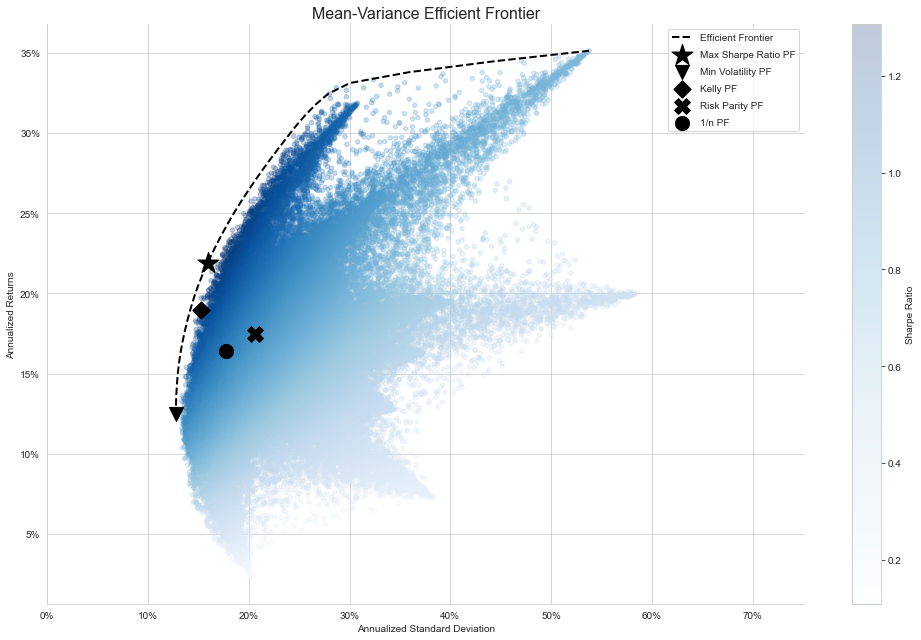

In [48]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();

# Clean-up
<hr style = "border:2px solid black" ></hr>

In [49]:
#1.54Gb
os.remove("./assets.h5")

# References
<hr style = "border:2px solid black" ></hr>


- [How to download the data](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/data/create_datasets.ipynb)
- [This notebook original code](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/05_strategy_evaluation/04_mean_variance_optimization.ipynb)
- Jansen, Stefan. Hands-On Machine Learning for Algorithmic Trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Packt Publishing Ltd, 2018.

